## Setup (paths + transform + model rebuild)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import cv2

# ------------ CONFIG (edit these if needed) ------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# Lesion crops (224x224) created earlier
CROP_IMG_DIR = Path("/kaggle/input/ham10000-segment-data/ham_lesion_crops")

# Trained PLA-MIL model checkpoint
MODEL_PATH = Path("/kaggle/input/pla-mil-network-model-outputs-ham10000/ham_plamil_outputs/best_plamil_model.pth")


CLASS_NAMES = ["MEL", "NV", "BCC", "AKIEC", "BKL", "DF", "VASC"]

IMG_SIZE = 224
PATCH_GRID = 4
PATCH_SIZE = IMG_SIZE // PATCH_GRID  # 56

# ------------ TRANSFORM ------------
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

Device: cuda


## Rebuild PLA-MIL model

In [2]:
class PatchEncoder(nn.Module):
    def __init__(self, out_dim=256):
        super().__init__()
        base = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.features = nn.Sequential(*list(base.children())[:-1])
        self.proj = nn.Linear(512, out_dim)

    def forward(self, x):
        feat = self.features(x)
        feat = feat.view(feat.size(0), -1)
        feat = self.proj(feat)
        return feat


class AttentionMIL(nn.Module):
    def __init__(self, dim, hidden_dim=128):
        super().__init__()
        self.attention_a = nn.Linear(dim, hidden_dim)
        self.attention_b = nn.Linear(hidden_dim, 1)

    def forward(self, H):
        A = torch.tanh(self.attention_a(H))
        A = self.attention_b(A).squeeze(-1)
        A = torch.softmax(A, dim=1)
        bag_repr = torch.sum(H * A.unsqueeze(-1), dim=1)
        return bag_repr, A


class PatchMILLesionClassifier(nn.Module):
    def __init__(self, num_classes=7, patch_dim=256):
        super().__init__()
        self.encoder = PatchEncoder(out_dim=patch_dim)
        self.mil_pool = AttentionMIL(dim=patch_dim, hidden_dim=128)
        self.classifier = nn.Sequential(
            nn.Linear(patch_dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, patches):
        B, N, C, H, W = patches.shape
        patches_flat = patches.view(B * N, C, H, W)
        patch_feats = self.encoder(patches_flat)
        D = patch_feats.shape[1]
        patch_feats = patch_feats.view(B, N, D)

        bag_repr, att_weights = self.mil_pool(patch_feats)
        logits = self.classifier(bag_repr)
        return logits, att_weights


# Load model
model = PatchMILLesionClassifier(num_classes=len(CLASS_NAMES), patch_dim=256).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()

print("PLA-MIL model loaded.")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 111MB/s]


PLA-MIL model loaded.


## Helper functions

In [3]:
def make_patches(img_pil):
    img_t = val_transform(img_pil)
    C, H, W = img_t.shape

    patches = img_t.unfold(1, PATCH_SIZE, PATCH_SIZE).unfold(2, PATCH_SIZE, PATCH_SIZE)
    patches = patches.permute(1, 2, 0, 3, 4)  
    patches = patches.reshape(-1, C, PATCH_SIZE, PATCH_SIZE)

    return patches.unsqueeze(0), img_t  # (1,N,3,H,W), (3,H,W)


def tensor_to_img01(img_t):
    img = img_t.cpu().numpy().transpose(1, 2, 0)
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    return np.clip(img, 0, 1)

## Grad-CAM (attention map) for ONE image

In [4]:
def run_plamil_gradcam(image_id):
    img_path = CROP_IMG_DIR / f"{image_id}.jpg"
    img_pil = Image.open(img_path).convert("RGB")

    patches, img_t = make_patches(img_pil)
    patches = patches.to(DEVICE)

    with torch.no_grad():
        logits, att = model(patches)
        probs = F.softmax(logits, dim=1)
        pred_idx = probs.argmax(dim=1).item()
        pred_class = CLASS_NAMES[pred_idx]

    att = att[0].cpu().numpy()
    att_norm = (att - att.min()) / (att.max() - att.min() + 1e-8)

    att_grid = att_norm.reshape(PATCH_GRID, PATCH_GRID)
    heatmap = cv2.resize(att_grid, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_CUBIC)

    img_vis = tensor_to_img01(img_t)
    heatmap_color = cv2.applyColorMap((heatmap * 255).astype(np.uint8), cv2.COLORMAP_JET)
    heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB) / 255.0

    overlay = (0.5 * heatmap_color + 0.5 * img_vis)
    overlay = np.clip(overlay, 0, 1)

    # -------- plot --------
    plt.figure(figsize=(14, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(img_vis)
    plt.title(f"Original\n{image_id}")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap, cmap="jet")
    plt.title("Heatmap (Attention)")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(overlay)
    plt.title(f"Overlay\nPredicted: {pred_class}")
    plt.axis("off")

    plt.show()

## Loop Grad-CAM for 5 Images

Selected images: ['ISIC_0028080', 'ISIC_0028945', 'ISIC_0033362', 'ISIC_0031280', 'ISIC_0026696']


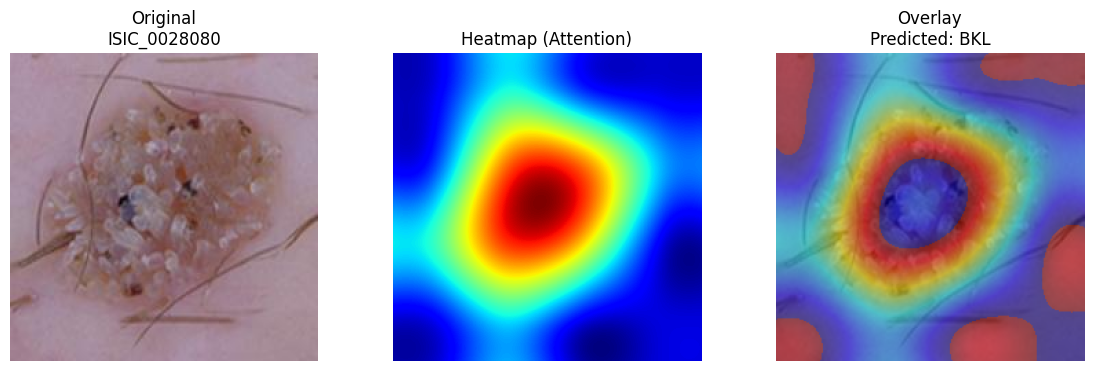

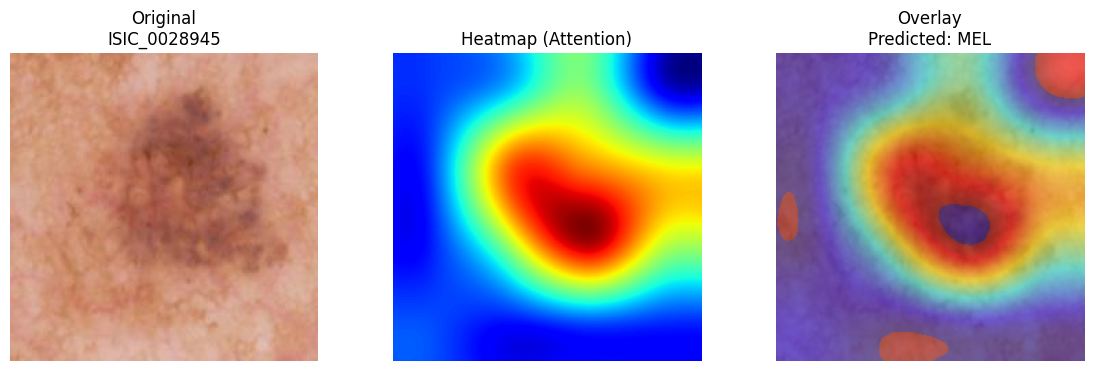

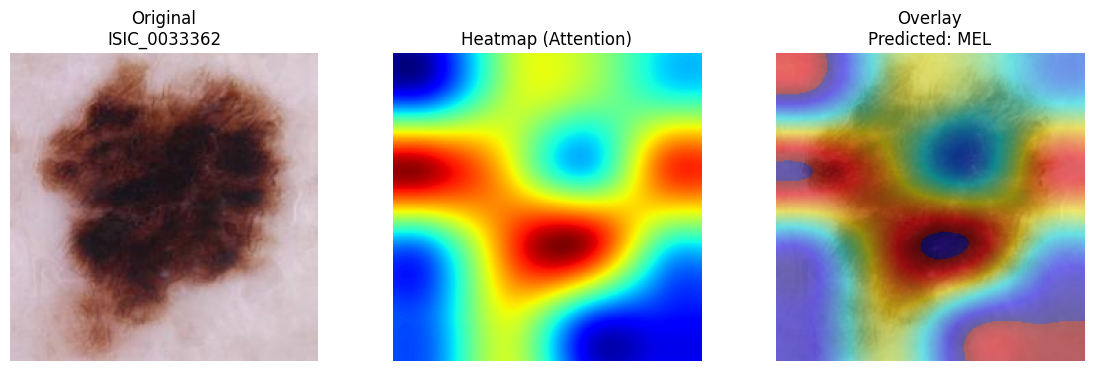

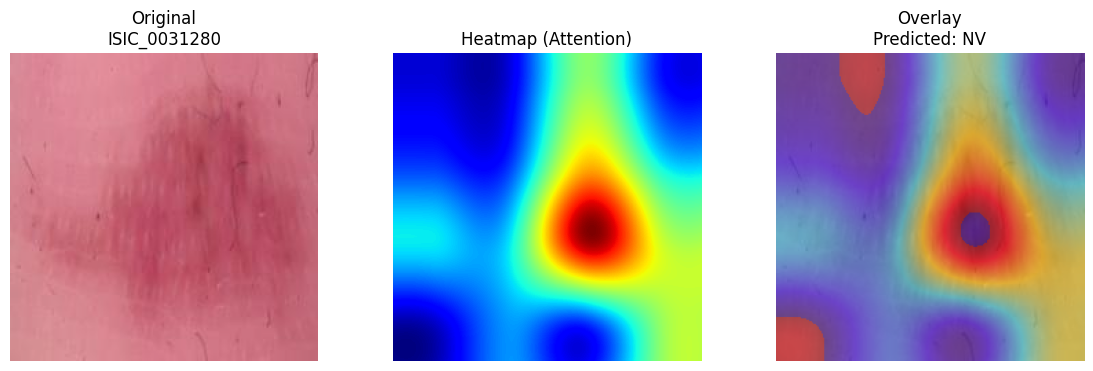

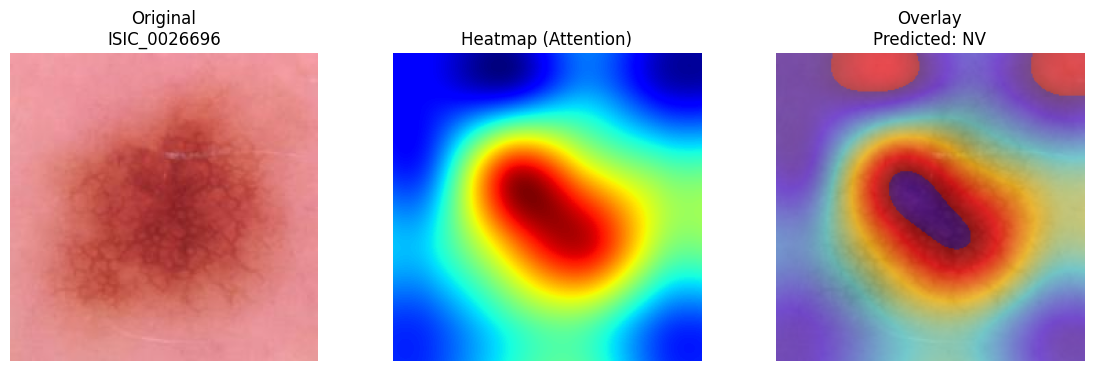

In [5]:
import random

# Get list of lesion crop image IDs
all_ids = [p.stem for p in CROP_IMG_DIR.glob("*.jpg")]

# Select 5 random ones
sample_ids = random.sample(all_ids, 5)

print("Selected images:", sample_ids)

for img_id in sample_ids:
    run_plamil_gradcam(img_id)